In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_5 = df.iloc[:, 4]
serie_5.head()

,#5
0,0.702293
1,0.699017
2,0.688780
3,0.674857
4,0.674447


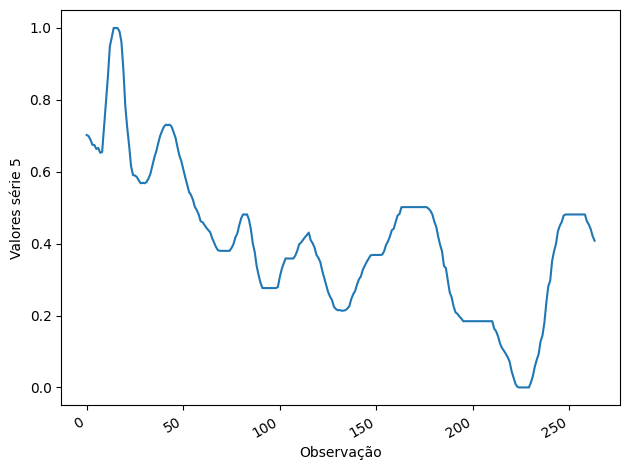

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_5)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 5')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

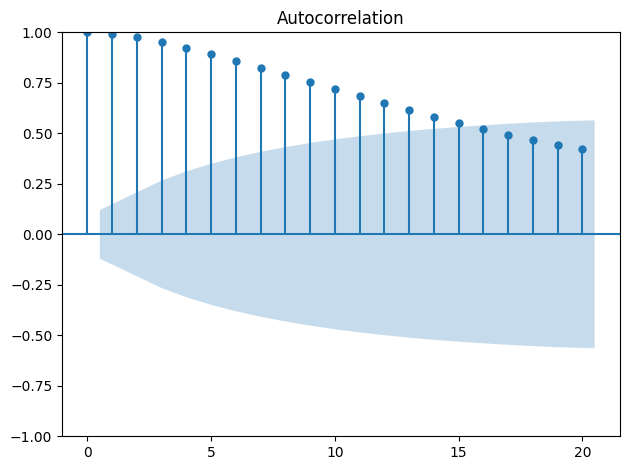

In [ ]:
plot_acf(serie_5, lags=20);
plt.tight_layout()

In [ ]:
advanced_decomposition = STL(serie_5,period=12).fit()

## Conjunto de treino

In [ ]:
test = pd.DataFrame()
test["Values"] = serie_5.iloc[-12:]
test['naive_seasonal'] = serie_5.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_5.iloc[-24:-12].mean()

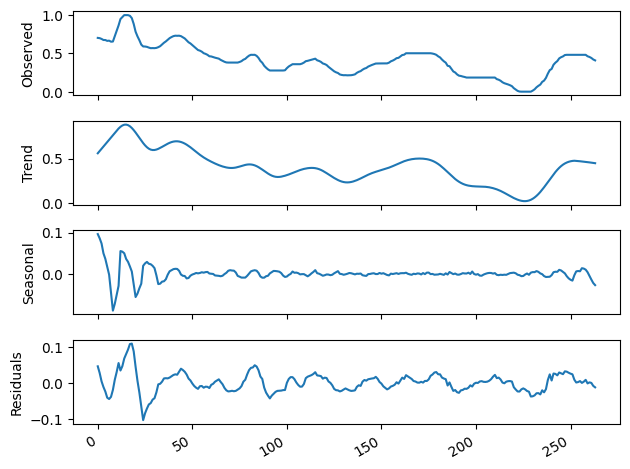

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [ ]:
check_stationarity(serie_5,seasonal_period=12)

{'adf_stat': -2.9682698971103827,
 'p_value': 0.03796572887076986,
 'stationary': True,
 'diffs_needed': 0,
 'seasonal_diffs_needed': 1}

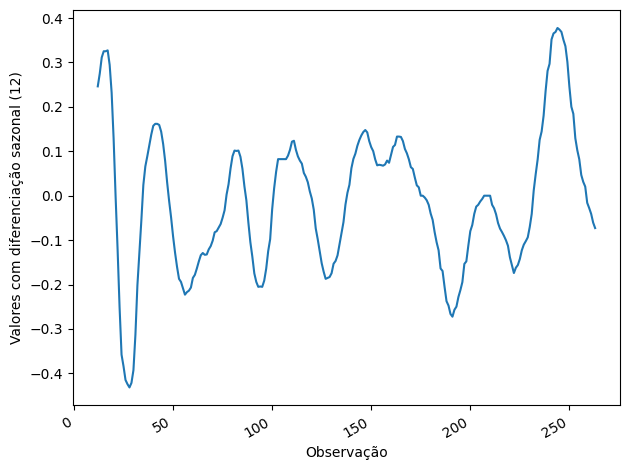

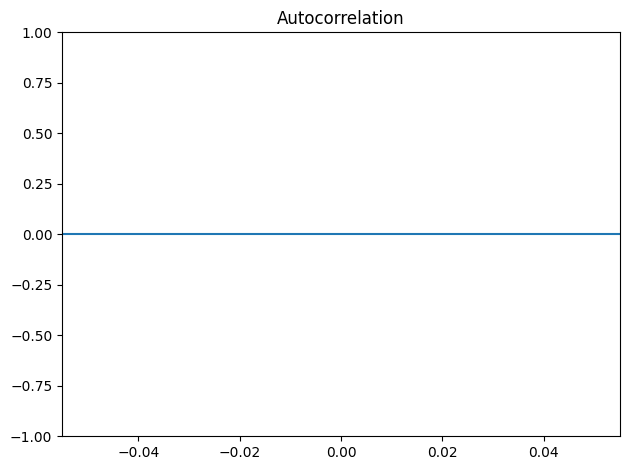

In [ ]:
seasonal_diff = serie_5.diff(12)
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [ ]:
train = serie_5[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(0,1,11) | AIC = -1557.544179 \\
* SARIMA(2,0,3)(0,1,1,12) | AIC = -1442.828489


In [ ]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(0,1,11), seasonal_order=(0,0,0,12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)



SARIMA_model = SARIMAX(train_transformed, order=(2,0,3), seasonal_order=(0,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.481163,0.296888,0.431238,0.474152,0.465358
253,0.481163,0.351761,0.431238,0.470821,0.456260
254,0.481163,0.378788,0.431238,0.469657,0.440811
255,0.481163,0.399263,0.431238,0.468034,0.420103
256,0.481163,0.434480,0.431238,0.465948,0.401708
257,0.481163,0.450041,0.431238,0.463619,0.376440
258,0.481163,0.460688,0.431238,0.461161,0.351333
259,0.462326,0.478296,0.431238,0.460487,0.330865
260,0.453317,0.481163,0.431238,0.461179,0.307232
261,0.440213,0.481163,0.431238,0.461662,0.290184


### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.957266
  2     0.991633
  3     0.998885
  4     0.999574
  5     0.999916
  6     0.999974
  7     0.999970
  8     0.999987
  9     0.996243
  10    0.998024
  11    0.999240
  12    0.999718
  13    0.999733
  14    0.999899
  15    0.999942
  16    0.999978
  17    0.999991
  18    0.999996
  19    0.999994
  20    0.999996
  21    0.999997
  22    0.999999
  23    1.000000
  24    1.000000
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0},
 'squared_residuals': {'p_values': 1     0.997890
  2     0.999994
  3     1.000000
  4     1.000000
  5     1.000000
  6     1.000000
  7     1.000000
  8     1.000000
  9     1.000000
  10    1.000000
  11    1.000000
  12    1.000000
  13    1.000000
  14    1.000000
  15    1.000000
  16    1.000000
  17    1.000000
  18    1.000000
  19    1.000000
  20    1.000000
  21    1.000000
  22    1.000000
  23    1.000000
  24    1.000000
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0}}

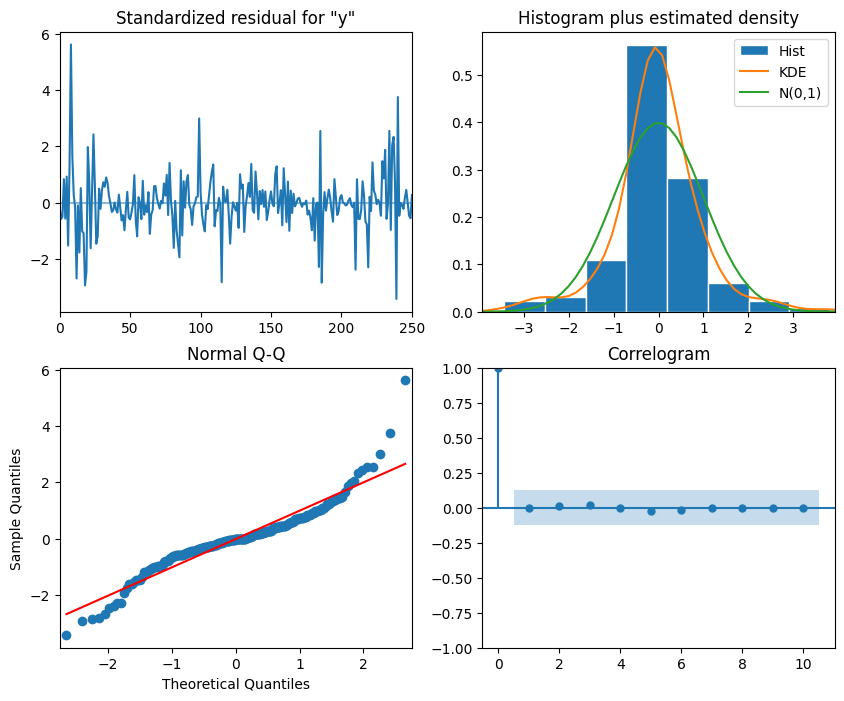

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1      1.456489e-48
  2      2.787371e-85
  3     8.038926e-115
  4     2.273414e-138
  5     8.611746e-157
  6     9.828126e-171
  7     1.424365e-180
  8     5.556652e-187
  9     1.529239e-190
  10    8.199863e-192
  11    1.502079e-191
  12    1.352530e-190
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 12},
 'squared_residuals': {'p_values': 1      1.989193e-45
  2      5.630518e-78
  3     2.120860e-103
  4     6.322086e-124
  5     3.647396e-140
  6     1.590469e-152
  7     1.573159e-161
  8     1.124938e-167
  9     1.880052e-171
  10    5.861274e-173
  11    1.009902e-172
  12    9.019923e-172
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 12}}

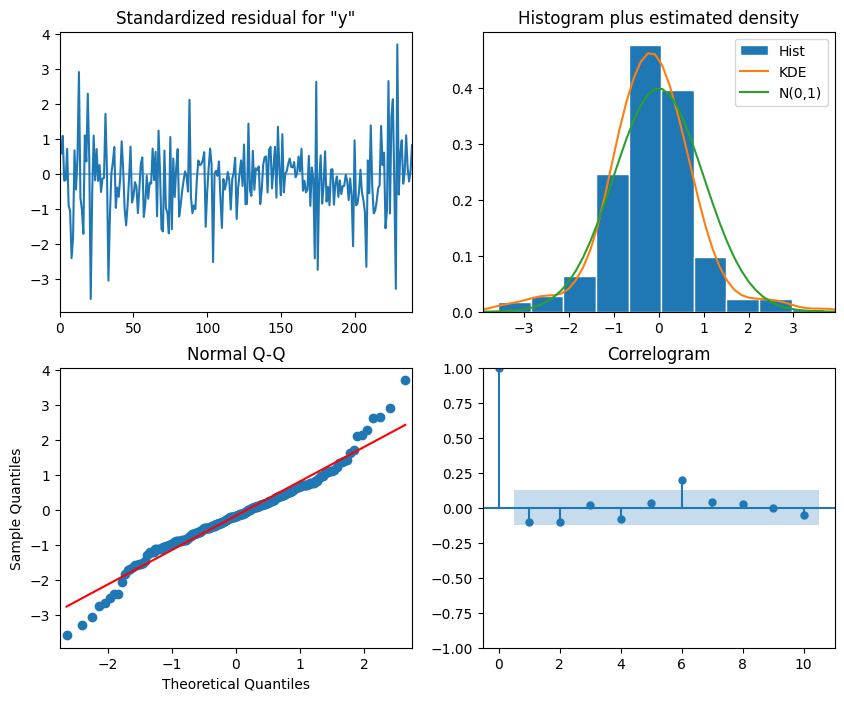

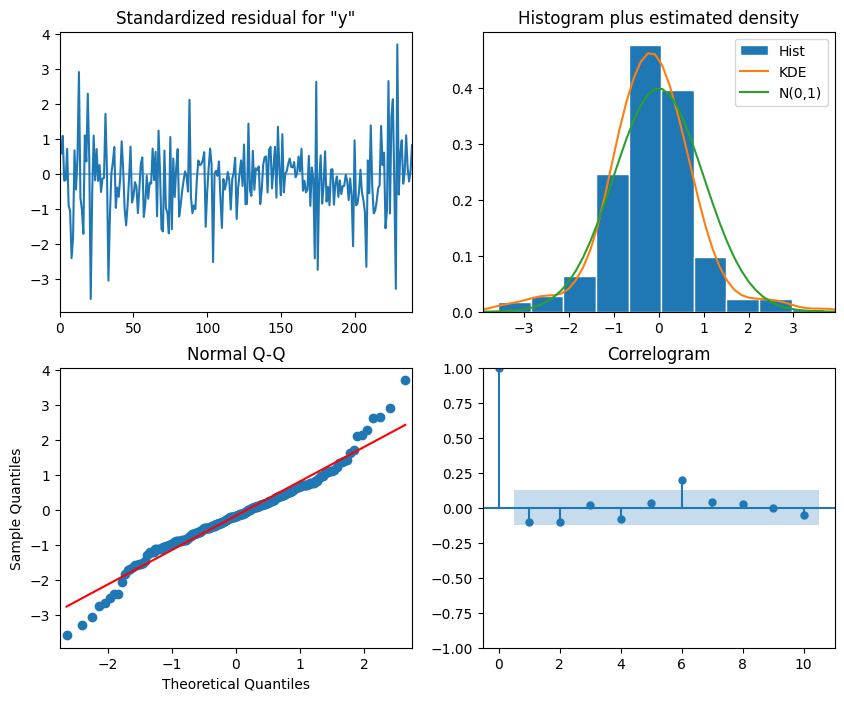

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_5[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add', damped_trend=True)
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.481163,0.296888,0.431238,0.474152,0.465358,0.481070,0.481101
253,0.481163,0.351761,0.431238,0.470821,0.456260,0.481009,0.481052
254,0.481163,0.378788,0.431238,0.469657,0.440811,0.480955,0.481003
255,0.481163,0.399263,0.431238,0.468034,0.420103,0.480909,0.480954
256,0.481163,0.434480,0.431238,0.465948,0.401708,0.480868,0.480906
257,0.481163,0.450041,0.431238,0.463619,0.376440,0.480832,0.480857
258,0.481163,0.460688,0.431238,0.461161,0.351333,0.480801,0.480808
259,0.462326,0.478296,0.431238,0.460487,0.330865,0.480774,0.480759
260,0.453317,0.481163,0.431238,0.461179,0.307232,0.480750,0.480711
261,0.440213,0.481163,0.431238,0.461662,0.290184,0.480729,0.480662


In [ ]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     0.657222
2     0.893829
3     0.000256
4     0.000075
5     0.000149
6     0.000130
7     0.000221
8     0.000444
9     0.000648
10    0.000114
11    0.000025
12    0.000046
13    0.000086
14    0.000139
15    0.000215
16    0.000371
17    0.000622
18    0.000697
19    0.000488
20    0.000415
Name: lb_pvalue, dtype: float64, 'lags_failed': 18}, 'squared_residuals': {'p_values': 1     0.001157
2     0.002853
3     0.002113
4     0.000103
5     0.000173
6     0.000051
7     0.000116
8     0.000235
9     0.000484
10    0.000011
11    0.000001
12    0.000003
13    0.000004
14    0.000008
15    0.000016
16    0.000024
17    0.000035
18    0.000059
19    0.000082
20    0.000130
Name: lb_pvalue, dtype: float64, 'lags_failed': 20}}


In [ ]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,0.014
Optimized:,True,AIC,-2454.016
Trend:,Additive,BIC,-2436.369
Seasonal:,None,AICC,-2453.557
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:43:09
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9184526,alpha,True
smoothing_trend,0.9184526,beta,True


## Theta

In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

# Fit the Theta model
theta_model = ThetaModel(train,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = theta_forecast.values
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                     #5   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:43:09   Period:                             12
Sample:                             0                                         
                                  252                                         
    Parameter Estimates     
            Parameters      
----------------------------
b0    -0.0021425417148109374
alpha     0.9998932546084723
----------------------------
Forecast: 252    0.482910
253    0.484944
254    0.484250
255    0.482081
256    0.482615
257    0.481846
258    0.477337
259    0.473268
260    0.465990
261    0.466732
262    0.467616
263    0.468308
Name: forecast, dtype: float64


## Visualização das predições


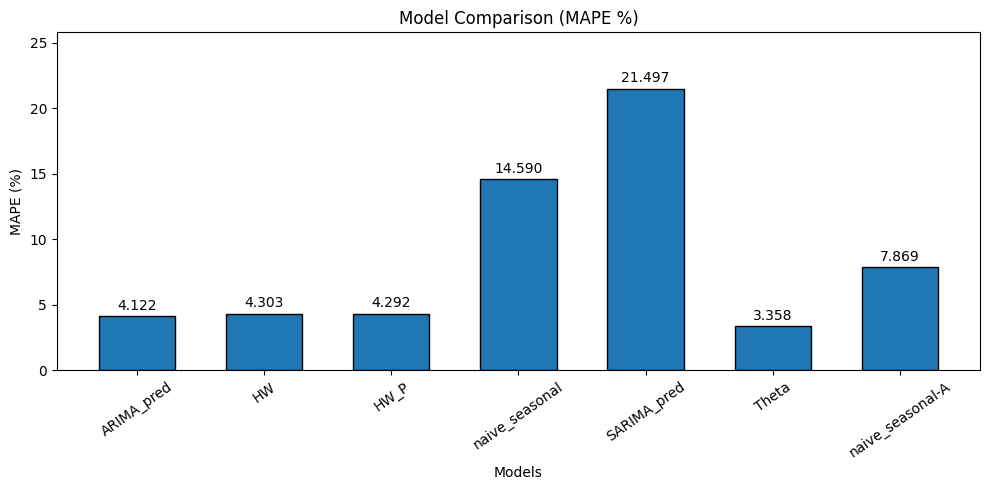

{'ARIMA_pred': 4.122140919698094,
 'HW': 4.30334525217593,
 'HW_P': 4.292443431284007,
 'naive_seasonal': 14.589899827961636,
 'SARIMA_pred': 21.49704743654128,
 'Theta': 3.35843169567148,
 'naive_seasonal-A': 7.8691412341458795}

In [ ]:
test['naive_seasonal'] = serie_5.iloc[-24:-12].values
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.481163,0.296888,0.431238,0.474152,0.465358,0.481070,0.481101,0.482910
253,0.481163,0.351761,0.431238,0.470821,0.456260,0.481009,0.481052,0.484944
254,0.481163,0.378788,0.431238,0.469657,0.440811,0.480955,0.481003,0.484250
255,0.481163,0.399263,0.431238,0.468034,0.420103,0.480909,0.480954,0.482081
256,0.481163,0.434480,0.431238,0.465948,0.401708,0.480868,0.480906,0.482615
257,0.481163,0.450041,0.431238,0.463619,0.376440,0.480832,0.480857,0.481846
258,0.481163,0.460688,0.431238,0.461161,0.351333,0.480801,0.480808,0.477337
259,0.462326,0.478296,0.431238,0.460487,0.330865,0.480774,0.480759,0.473268
260,0.453317,0.481163,0.431238,0.461179,0.307232,0.480750,0.480711,0.465990
261,0.440213,0.481163,0.431238,0.461662,0.290184,0.480729,0.480662,0.466732


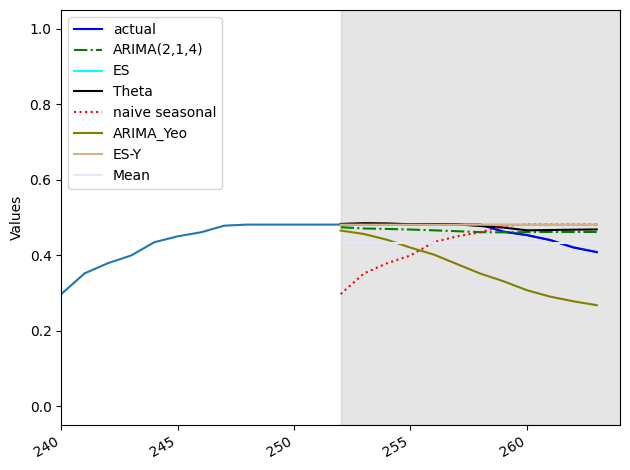

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_5)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA(2,1,4)')
ax.plot(test['HW'], 'cyan', label='ES')
ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
ax.plot(test['HW_P'], 'tan', label='ES-Y')
ax.plot(test['naive_seasonal-A'] , 'lavender', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

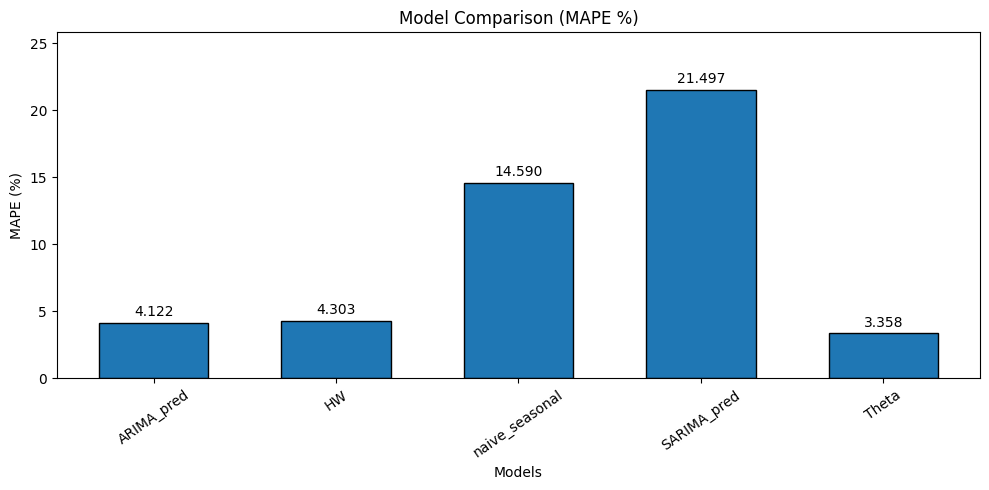

{'ARIMA_pred': 4.122140919698094,
 'HW': 4.30334525217593,
 'naive_seasonal': 14.589899827961636,
 'SARIMA_pred': 21.49704743654128,
 'Theta': 3.35843169567148}

In [ ]:
columns = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred','Theta']
plot_model_mape(test,'Values',columns)

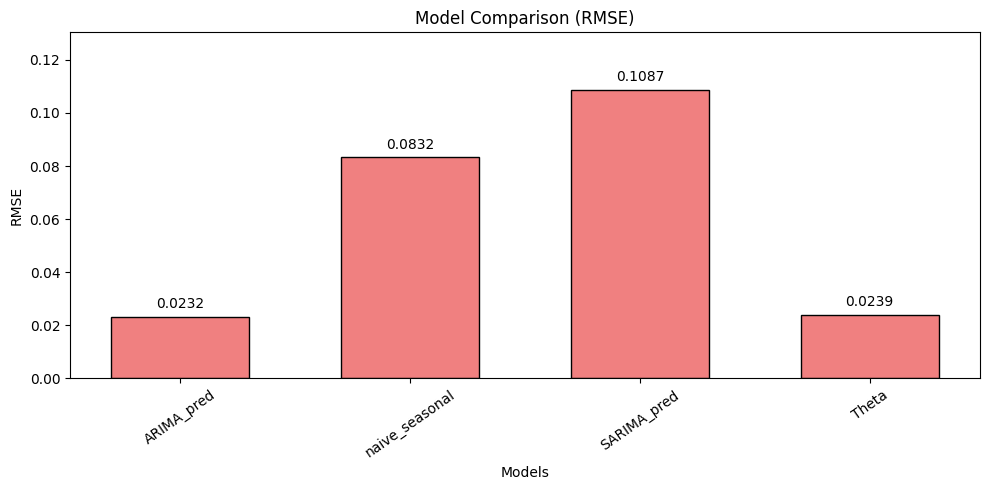

In [ ]:
columns_to_plot = ['ARIMA_pred','naive_seasonal','SARIMA_pred', 'Theta']

rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [ ]:
theta_model = ThetaModel(serie_5,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
theta_forecast

,forecast
264,0.409952
265,0.411999
266,0.411543
267,0.409732
268,0.410560
269,0.410211
270,0.406338
271,0.402797
272,0.395660
273,0.396120


In [ ]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(theta_forecast)
with open("5.csv", "w") as f:
    for i, value in enumerate(theta_forecast, 1):
        f.write(f"{value:};\n")